Copyright @ 2021 ABCOM Information Systems Pvt. Ltd. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.


# Customer Segmentation using K-Means Clustering

# Description

The main aim of this problem is learning the purpose of the customer segmentation concepts, also known as market basket analysis, trying to understand customers and sepparate them in different groups according to their preferences, and once the division is done, this information can be given to marketing team so they can plan the strategy accordingly.

Dataset Link: https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# Data Exploration 

In [2]:
!wget https://raw.githubusercontent.com/abcom-mltutorials/mall/main/Mall_Customers.csv

--2021-05-31 12:41:13--  https://raw.githubusercontent.com/abcom-mltutorials/mall/main/Mall_Customers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3780 (3.7K) [text/plain]
Saving to: ‘Mall_Customers.csv’

Mall_Customers.csv  100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-05-31 12:41:13 (59.4 MB/s) - ‘Mall_Customers.csv’ saved [3780/3780]



In [3]:
data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
data.shape

(200, 5)

In [5]:
#Changing the name of some columns

data = data.rename(columns={'Annual Income (k$)': 'Annual_income', 'Spending Score (1-100)': 'Spending_score'})

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual_income   200 non-null    int64 
 4   Spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
data.describe()

,CustomerID,Age,Annual_income,Spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


# Data Cleaning

In [8]:
#Checking for null values

data.isnull().sum()

CustomerID        0
Gender            0
Age               0
Annual_income     0
Spending_score    0
dtype: int64

In [9]:
# Replacing objects with numerical values

data.Gender.replace('Male', 0, inplace=True)
data.Gender.replace('Female', 1, inplace=True)
data

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40
...,...,...,...,...,...
195,196,1,35,120,79
196,197,1,45,126,28
197,198,0,32,126,74
198,199,0,32,137,18


# Data Visualization

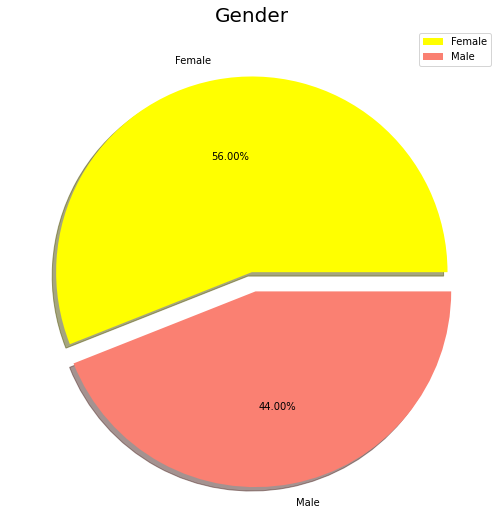

In [10]:
labels = ['Female', 'Male']
size = data['Gender'].value_counts()
colors = ['yellow', 'salmon']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

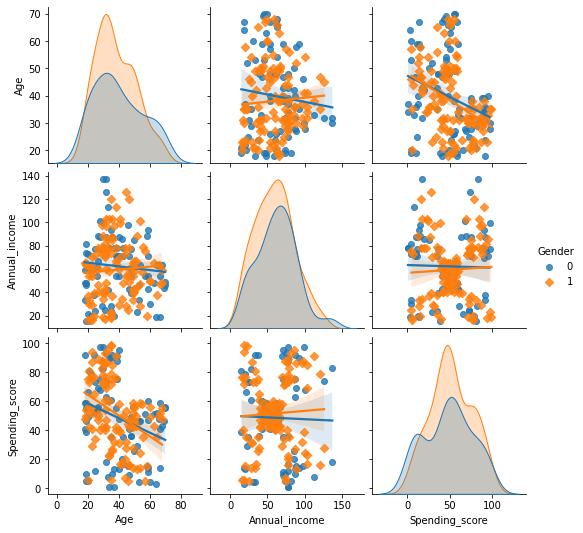

In [11]:
#Pairplot with variables we want to study

sns.pairplot(data, vars=["Age", "Annual_income", "Spending_score"],  kind ="reg", hue = "Gender", markers = ['o','D'])

# Preparing data for modelling

In [12]:
data.head()

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [13]:
# Preserve the CutomerID & Gender column to a variable, so that we can make use of it later

data_id = data[['CustomerID','Gender']].copy() 
data_id.head()

,CustomerID,Gender
0,1,0
1,2,0
2,3,1
3,4,1
4,5,1


In [14]:
# Now let's drop the CustomerID & Gender column as it is not a predictor in our data.

data_predictor = data.drop(['CustomerID', 'Gender'], axis=1)
data_predictor.head()

,Age,Annual_income,Spending_score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


# K-Means Clustering

It's time to decide the amount of clusters we want to divide our data in. To do so, we are going to use the Silhouette Method & Elbow Method.

# Silhouette Analysis

In [15]:
# Importing Silhouette score module
from sklearn.metrics import silhouette_score

for num_clusters in range(2,10):
    # Instantiate k-means
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=50)
    # Fit the 
    kmeans.fit(data_predictor)
    # Labels of each cluster point 
    cluster_labels = kmeans.labels_
    
    silhoutte_avg = silhouette_score(data_predictor, cluster_labels)
    print("For n_clusters={0} the silhouette score={1}".format(num_clusters, silhoutte_avg))

For n_clusters=2 the silhouette score=0.293166070535953
For n_clusters=3 the silhouette score=0.3839349967742105
For n_clusters=4 the silhouette score=0.40546302077733304
For n_clusters=5 the silhouette score=0.44045315045641703
For n_clusters=6 the silhouette score=0.4523443947724053
For n_clusters=7 the silhouette score=0.4397701124821705
For n_clusters=8 the silhouette score=0.42631940650028766
For n_clusters=9 the silhouette score=0.41197801912451715


<span style = "color:blue">We can see that according to Silhouette analysis:</span>

Silhouette score for 5 clusters = 0.44

Silhouette score for 6 clusters = 0.45

# Elbow Method

SSD (Sum of squared distance) of the points of their respective clusters. Lesser the SSD, then number of cluster is optimum.

Text(0, 0.5, 'Inertia')

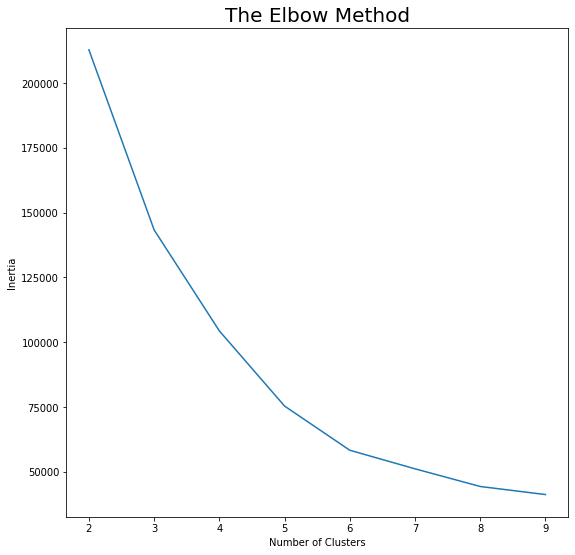

In [16]:
ssd = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k).fit(data_predictor)
    ssd.append([k, kmeans.inertia_])
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters') 
plt.ylabel('Inertia')

The elbow method is used to determine the optimal number of clusters in k-means clustering. The elbow method plots the value of the cost function produced by different values of k and one should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. In this problem, we are using the inertia as cost function in order to identify the sum of squared distances of samples to the nearest cluster centre.

Looking at this particular example, if we imagine the line in the graphic is an arm, the elbow can be found, approximately, where the number of clusters is equal to 5. Therefore we are selecting 5 as the number of clusters to divide our data in.

In [17]:
# Instantiate the K-Means with k=5
kmeans = KMeans(n_clusters=5, max_iter=50, random_state=50)

# Fit the model
kmeans.fit(data_predictor)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [18]:
kmeans.labels_

array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1], dtype=int32)

In [19]:
# Copying data_predictor dataframe to data_kmeans

data_kmeans = data_predictor.copy()

In [20]:
# Adding the cluster labels to the dataframe

data_kmeans['ClusterID'] = kmeans.labels_
data_kmeans.head()

,Age,Annual_income,Spending_score,ClusterID
0,19,15,39,4
1,21,15,81,2
2,20,16,6,4
3,23,16,77,2
4,31,17,40,4


In [21]:
# Check the count of observation per cluster

data_kmeans['ClusterID'].value_counts()

0    77
1    39
3    36
2    25
4    23
Name: ClusterID, dtype: int64

In [22]:
# Concat data_id and data_kmeans

data_kmeans = pd.concat([data_id, data_kmeans], axis=1)
data_kmeans.head()

,CustomerID,Gender,Age,Annual_income,Spending_score,ClusterID
0,1,0,19,15,39,4
1,2,0,21,15,81,2
2,3,1,20,16,6,4
3,4,1,23,16,77,2
4,5,1,31,17,40,4


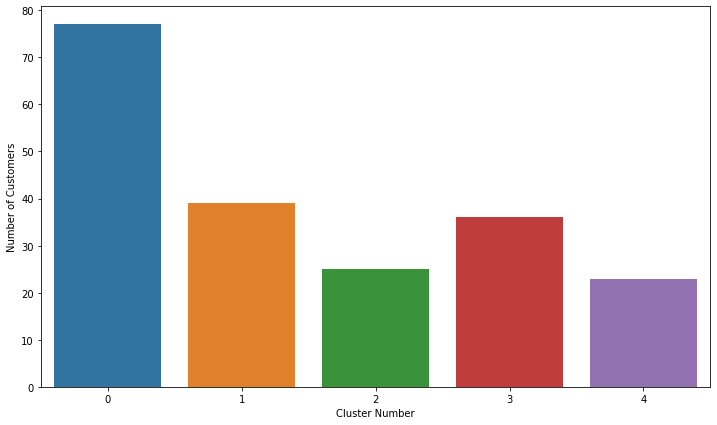

In [23]:
# Plotting the clusters count

plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,5,1),y=data_kmeans.groupby(['ClusterID']).count()['CustomerID'].values)
x=axis.set_xlabel("Cluster Number")
x=axis.set_ylabel("Number of Customers")

We can see that Cluster-0 has 77, Cluster-1 has 39, Cluster-2 has 25, Cluster-3 has 36 and Cluster-4 has 23 customers.

# Cluster Profiling K-Means 

In [24]:
#Merging the original data with Cluster Id

data_clustered = pd.merge(data, data_kmeans[['CustomerID','ClusterID']], on='CustomerID')
data_clustered.head()

,CustomerID,Gender,Age,Annual_income,Spending_score,ClusterID
0,1,0,19,15,39,4
1,2,0,21,15,81,2
2,3,1,20,16,6,4
3,4,1,23,16,77,2
4,5,1,31,17,40,4


# Age & Annual Income

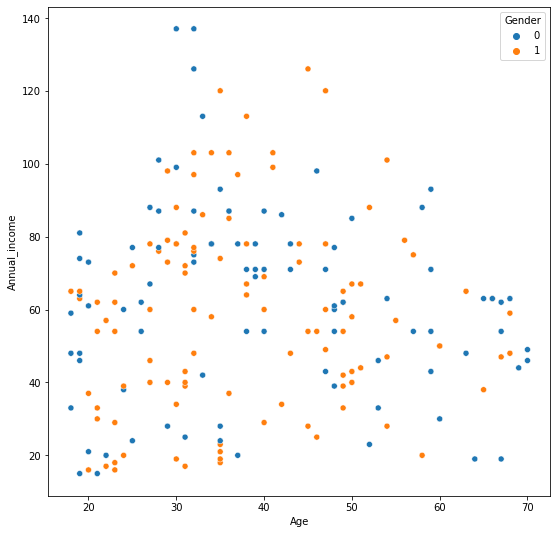

In [25]:
sns.scatterplot(x = "Age", y = "Annual_income", data = data_clustered, hue = "Gender")

# Spending Score & Annual Income

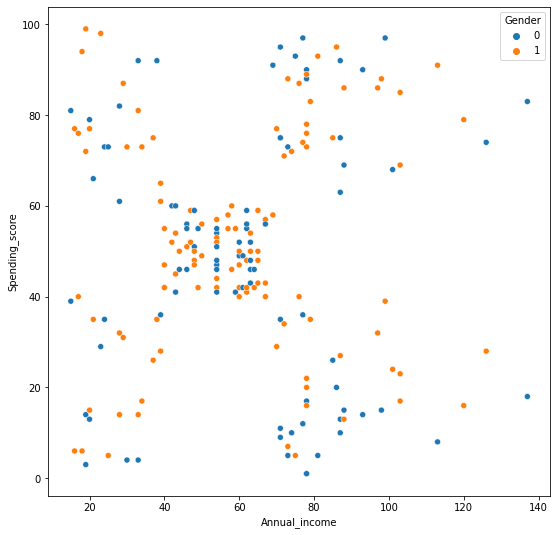

In [26]:
sns.scatterplot(x = "Annual_income", y = "Spending_score", data = data_clustered, hue = "Gender")

# Age & Spending Score

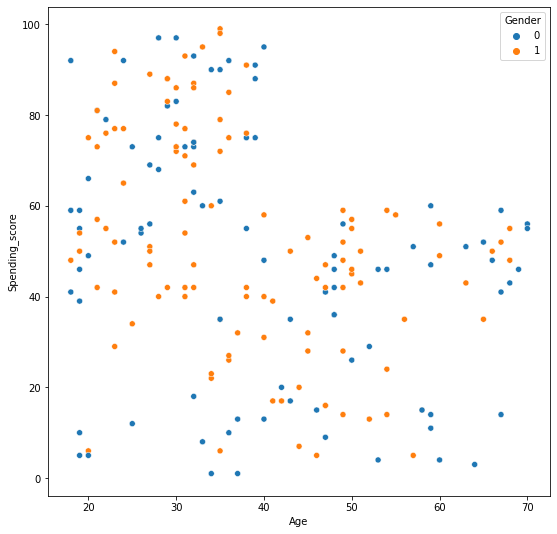

In [27]:
sns.scatterplot(x = "Age", y = "Spending_score", data = data_clustered, hue = "Gender")

# Analysis of K-Means Cluster

In [28]:
#Checking the mean of Age, Annual_income and Spending_score for each cluster

data_clustered[['Age', 'Annual_income', 'Spending_score', 'ClusterID']].groupby('ClusterID').mean()

,Age,Annual_income,Spending_score
ClusterID,,,
0,43.727273,55.480519,49.324675
1,32.692308,86.538462,82.128205
2,24.960000,28.040000,77.000000
3,40.666667,87.750000,17.583333
4,45.217391,26.304348,20.913043


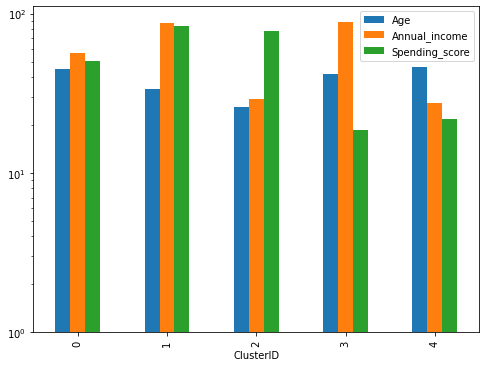

In [29]:
# Plotting the mean of the variables for each cluster

data_clustered[['Age', 'Annual_income', 'Spending_score', 'ClusterID']].groupby('ClusterID').mean().plot(kind='bar',log=True,figsize = (8,6))

# Checking the distribution of Age, Annual_income and Spending_score variables for each cluster

In [30]:
var_analysis = ['Age', 'Annual_income', 'Spending_score']

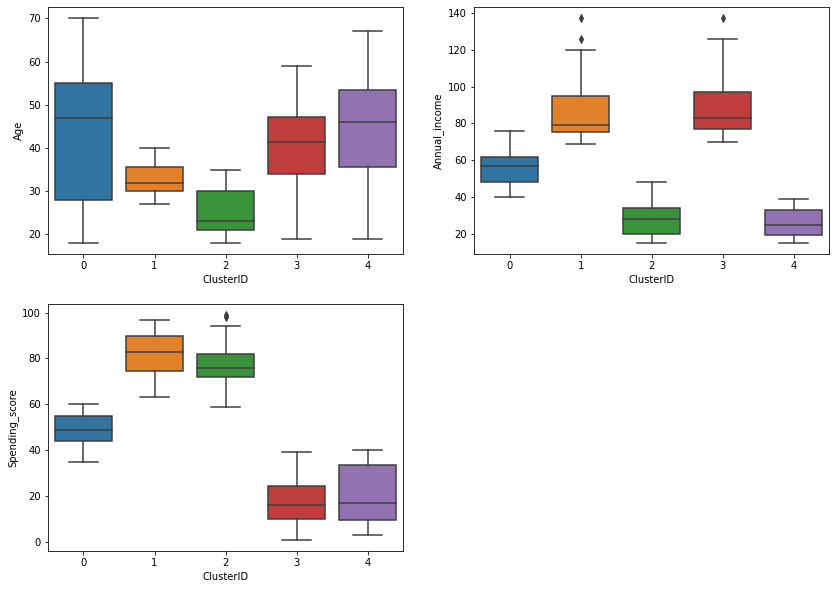

In [31]:
plt.figure(figsize = (14,10))
for i in enumerate(var_analysis):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(x= 'ClusterID', y = i[1], data = data_clustered)

# Clustering

In [32]:
#Training kmeans with 5 clusters

means_k = KMeans(n_clusters=5, random_state=0)
means_k.fit(data_predictor)
labels = means_k.labels_
centroids = means_k.cluster_centers_

3-D Visualizations

In [35]:
#Create a 3d plot to view the data sepparation made by Kmeans

trace1 = go.Scatter3d(
    x= data_predictor['Spending_score'],
    y= data_predictor['Annual_income'],
    z= data_predictor['Age'],
    mode='markers',
     marker=dict(
        color = labels, 
        size= 10,
        line=dict(
            color= labels,
        ),
        opacity = 0.9
     )
)
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Spending_score'),
            yaxis = dict(title  = 'Annual_income'),
            zaxis = dict(title  = 'Age')
        )
)
fig = go.Figure(data=trace1, layout=layout)
py.offline.iplot(fig)

After plotting the results obtained by K-means on this 3D graphic, it's our job now to identify and describe the five clusters that have been created:

Yellow Cluster - The yellow cluster groups young people with moderate to low annual income who actually spend a lot

Purple Cluster - The purple cluster groups reasonably young people with pretty decent salaries who spend a lot

Pink Cluster - The pink cluster basically groups people of all ages whose salary isn't pretty high and their spending score is moderate

Orange Cluster - The orange cluster groups people who actually have pretty good salaries and barely spend money, their age usually lays between thirty and sixty years

Blue Cluster - The blue cluster groups whose salary is pretty low and don't spend much money in stores, they are people of all ages.